In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import json
from utils.transformations import min_max_normalization, inverse_min_max_normalization, transform_to_sparse, inverse_transform_to_sparse


train_dataset = pd.read_csv("../data/adult.csv")
instance_to_explain_index = 2

with open('../data/adult_constraints.json', 'r') as f:
    constr = json.load(f)

train_dataset = train_dataset[constr['features_order_nonsplit']]
train_dataset.columns

Index(['hours.per.week', 'age', 'capital.loss', 'education.num',
       'capital.gain', 'workclass', 'marital.status', 'occupation', 'race',
       'sex', 'native.country', 'income'],
      dtype='object')

In [2]:
query_instance = train_dataset.drop(columns="income")[instance_to_explain_index:instance_to_explain_index+1]

all_counterfactuals = pd.DataFrame(columns=train_dataset.columns.tolist() + ['explainer'])

In [3]:
query_instance

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country
2,40,66,4356,10,0,?,Widowed,?,Black,Female,United-States


In [4]:
from dice import DiceModel

dice_model = DiceModel(
    train_dataset=train_dataset,
    continuous_features=constr['continuous_features_nonsplit'],
    categorical_features=constr['categorical_features_nonsplit'],
    target=constr['target_feature'],
    model_path='../models/adult_NN/',
    backend='TF2',
    func='ohe-min-max',
)

dice_counterfactuals_df = dice_model.generate_counterfactuals(
    query_instance=query_instance,
    total_CFs=40,
    desired_class='opposite',
    features_to_vary=constr['actionable_features'],
    permitted_range=constr['feature_ranges'],
)

dice_counterfactuals_df['explainer'] = 'dice'
all_counterfactuals = pd.concat([all_counterfactuals, dice_counterfactuals_df], ignore_index=True)

100%|██████████| 1/1 [00:07<00:00,  7.77s/it]


In [5]:
all_counterfactuals.head(5)

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,income,explainer
0,1.0,56.0,4356.0,10.0,0.0,?,Widowed,?,Black,Female,United-States,0,dice
1,5.0,46.0,4356.0,5.0,62744.0,?,Widowed,Armed-Forces,Black,Female,United-States,0,dice
2,9.0,19.0,4356.0,10.0,0.0,Without-pay,Widowed,?,Black,Female,United-States,0,dice
3,2.0,66.0,4356.0,10.0,0.0,?,Widowed,?,Black,Female,United-States,0,dice
4,6.0,26.0,4356.0,10.0,0.0,Private,Widowed,?,Black,Female,United-States,0,dice


In [6]:
import alibi
import tensorflow as tf
from alibi.explainers import Counterfactual 

tf.compat.v1.disable_eager_execution()


# Transform dataset to sparse
train_dataset_sparse = transform_to_sparse(
    _df=train_dataset.drop(columns="income"),
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Min-max normalization
train_dataset_sparse_normalized = min_max_normalization(
    _df=train_dataset_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

query_instance_sparse_normalized = train_dataset_sparse_normalized[instance_to_explain_index:instance_to_explain_index+1]



# Define the model
model = tf.keras.models.load_model('../models/adult_NN/')

shape = query_instance_sparse_normalized.shape


cf = Counterfactual(model, shape, distance_fn='l1', target_proba=1.0,
                    target_class='other', max_iter=1000, early_stop=50, lam_init=1e-1,
                    max_lam_steps=15, tol=0.3, learning_rate_init=0.1,
                    feature_range=(0, 1), eps=0.1, init='identity',
                    decay=True, write_dir=None, debug=False)

# Get Explanation
explanation = cf.explain(query_instance_sparse_normalized)


c:\ProgramData\Anaconda3\envs\cf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\ProgramData\Anaconda3\envs\cf\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [7]:
wachter_counterfactuals = []
for key, lst in explanation['data']['all'].items():
    if lst:
        for cf in lst:
            wachter_counterfactuals.append(cf['X'])

wachter_counterfactuals = np.array(wachter_counterfactuals).reshape(-1, shape[1])

wachter_counterfactuals_df = pd.DataFrame(wachter_counterfactuals, columns=constr['features_order_after_split'])

# Inverse min-max normalization
wachter_counterfactuals_df = inverse_min_max_normalization(
    _df=wachter_counterfactuals_df,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Inverse transform to sparse
wachter_counterfactuals_df = inverse_transform_to_sparse(
    sparse_df=wachter_counterfactuals_df,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

wachter_counterfactuals_df['explainer'] = 'wachter'

all_counterfactuals = pd.concat([all_counterfactuals, wachter_counterfactuals_df], ignore_index=True)

wachter_counterfactuals_df.head(5)

C:\Users\ignacy\AppData\Local\Temp\ipykernel_7340\2927160783.py:2: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  for key, lst in explanation['data']['all'].items():
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')


,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,explainer
0,49,17,4088,10,9127,?,Widowed,?,Black,Female,United-States,wachter
1,45,17,3884,9,4139,?,Widowed,?,Black,Female,United-States,wachter
2,41,17,3717,9,0,?,Widowed,?,Black,Female,United-States,wachter
3,39,17,3580,8,0,?,Widowed,?,Black,Female,United-States,wachter
4,36,17,3467,8,0,?,Widowed,?,Black,Female,United-States,wachter


In [8]:
wachter_counterfactuals_df.shape

(519, 12)

ECE

In [9]:
# from cfec_ece import CfecEceModel 
# import tensorflow as tf

# model = tf.keras.models.load_model('../models/adult_NN/')

# model_predictions = model.predict(train_dataset.drop(columns="income"))
# model_predictions = np.argmax(model_predictions, axis=1)

# cfec_model = CfecEceModel(
#     train_dataset=train_dataset,
#     model_predictions=model_predictions,
#     )

# cfec_counterfactuals = cfec_model.generate_counterfactuals(query_instance=query_instance)

VISUALIZATION

In [10]:
from visualization_helpers import get_scores
from visualization_helpers import remove_duplicates

all_counterfactuals = remove_duplicates(all_counterfactuals)
print('Counterfactuals: ', all_counterfactuals.shape)

# Transform counterfactuals to sparse
counterfactuals_sparse = transform_to_sparse(
    _df=all_counterfactuals,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Normalize counterfactuals
counterfactuals_sparse_normalized = min_max_normalization(
    _df=counterfactuals_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)


# Transform query instance to sparse
query_instance_sparse = transform_to_sparse(
    _df=query_instance,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Normalize query instance sparse
query_instance_sparse_normalized = min_max_normalization(
    _df=query_instance_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Mask non actionable features
mask_indices = [1 if any([act in x for act in constr['actionable_features']]) else 0 for x in constr['features_order_after_split']]

Counterfactuals:  (536, 13)


In [11]:
from visualization_helpers import filter_non_valid
predict_fn = lambda x: model.predict(x)

valid_counterfactuals_sparse_normalized = filter_non_valid(predict_fn, query_instance_sparse_normalized, counterfactuals_sparse_normalized)
valid_counterfactuals_sparse_normalized.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            429, 430, 431, 432, 433, 434, 435, 436, 437, 438],
           dtype='int64', length=251)

In [12]:
valid_counterfactuals = all_counterfactuals.iloc[valid_counterfactuals_sparse_normalized.index]
valid_counterfactuals['income'] = np.argmax(predict_fn(valid_counterfactuals_sparse_normalized.to_numpy()[0:1]))
valid_counterfactuals.reset_index(drop=True, inplace=True)
valid_counterfactuals

C:\Users\ignacy\AppData\Local\Temp\ipykernel_7340\647132470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_counterfactuals['income'] = np.argmax(predict_fn(valid_counterfactuals_sparse_normalized.to_numpy()[0:1]))


,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,income,explainer
0,1.0,56.0,4356.0,10.0,0.0,?,Widowed,?,Black,Female,United-States,0,dice
1,5.0,46.0,4356.0,5.0,62744.0,?,Widowed,Armed-Forces,Black,Female,United-States,0,dice
2,9.0,19.0,4356.0,10.0,0.0,Without-pay,Widowed,?,Black,Female,United-States,0,dice
3,2.0,66.0,4356.0,10.0,0.0,?,Widowed,?,Black,Female,United-States,0,dice
4,6.0,26.0,4356.0,10.0,0.0,Private,Widowed,?,Black,Female,United-States,0,dice
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,20.0,17.0,2623.0,4.0,0.0,?,Widowed,?,Black,Female,United-States,0,wachter
247,21.0,17.0,2649.0,4.0,0.0,?,Widowed,?,Black,Female,United-States,0,wachter
248,21.0,17.0,2676.0,4.0,0.0,?,Widowed,?,Black,Female,United-States,0,wachter
249,22.0,17.0,2704.0,4.0,0.0,?,Widowed,?,Black,Female,United-States,0,wachter


In [13]:
scores_df = get_scores(valid_counterfactuals_sparse_normalized.to_numpy(), query_instance_sparse_normalized, train_dataset_sparse_normalized, train_dataset['income'], mask_indices)

In [14]:
from visualization_helpers import filter_non_actionable
valid_counterfactuals = filter_non_actionable(valid_counterfactuals, query_instance, constr['non_actionable_features'])

(251, 3)
(1, 3)


In [15]:
scores_df['explainer'] = valid_counterfactuals['explainer']
scores_df

,cf,proximity,features_changed,feasibility,actionability,preference_dcg,discriminative_power,dispreference_dcg,non_discriminative_power,explainer
0,"[0.0, 0.5342465753424658, 1.0, 0.6, 0.0, 1.0, ...",0.534945,2,1.024052,True,0.136986,0.0,1.185757,1.0,dice
1,"[0.04081632653061224, 0.3972602739726027, 1.0,...",3.591895,6,3.485739,True,0.710866,0.0,0.611878,1.0,dice
2,"[0.08163265306122448, 0.0273972602739726, 1.0,...",2.960162,4,3.103423,True,1.030688,0.0,0.292055,1.0,dice
3,"[0.01020408163265306, 0.6712328767123288, 1.0,...",0.387755,1,1.014567,True,0.000000,0.0,1.322744,1.0,dice
4,"[0.05102040816326531, 0.1232876712328767, 1.0,...",2.894884,4,2.504198,True,0.934798,0.0,0.387946,1.0,dice
...,...,...,...,...,...,...,...,...,...,...
246,"[0.19387755102040816, 0.0, 0.602157943067034, ...",1.673157,4,0.552331,True,1.122243,0.0,0.200500,1.0,wachter
247,"[0.20408163265306123, 0.0, 0.6081267217630854,...",1.656984,4,0.555494,True,1.118477,0.0,0.204266,1.0,wachter
248,"[0.20408163265306123, 0.0, 0.6143250688705234,...",1.650785,4,0.563072,True,1.114567,0.0,0.208177,1.0,wachter
249,"[0.21428571428571427, 0.0, 0.620752984389348, ...",1.634153,4,0.567158,True,1.110511,0.0,0.212232,1.0,wachter


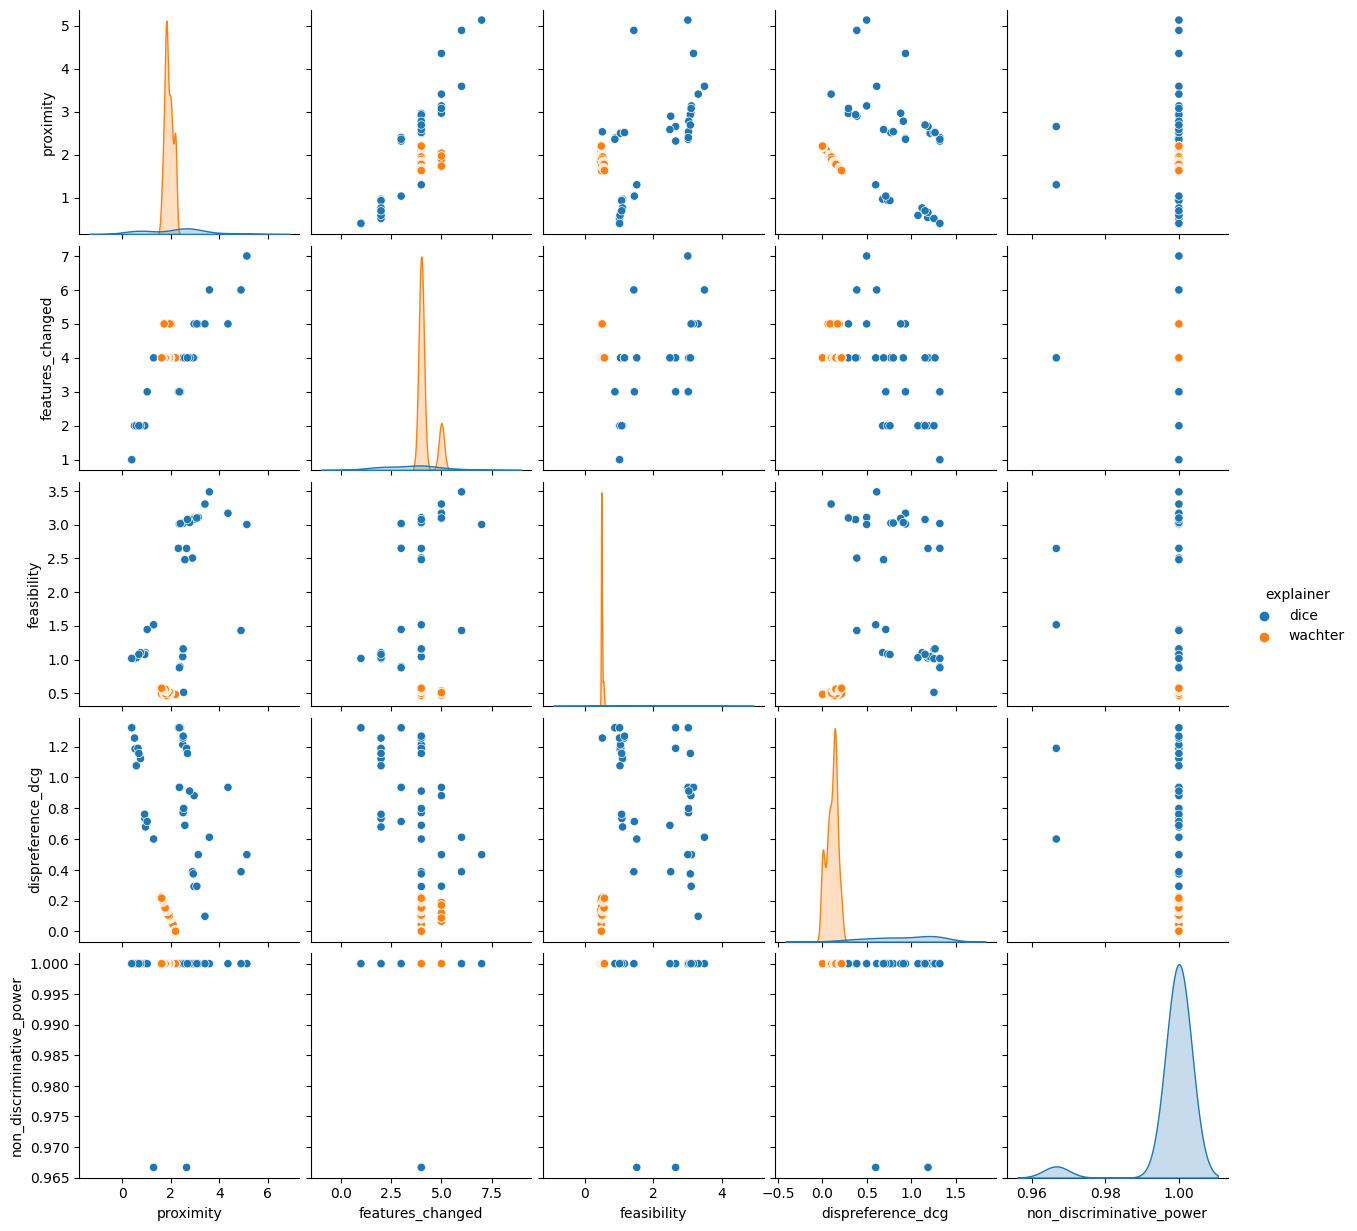

In [16]:
import seaborn as sns

scores_to_plot = scores_df.drop(['cf', 'actionability', 'preference_dcg', 'discriminative_power'], axis=1)

# Pairplot
sns.pairplot(scores_to_plot, hue="explainer", diag_kind='kde')

In [17]:
def get_pareto_frontier_mask(to_check: np.ndarray) -> np.ndarray:
    '''  
    Returns a mask of the pareto frontier of the input array.
    
    Both criteria are assumed to be minimized.
    '''
    assert to_check.shape[1] == 2, "Can only handle 2D arrays"

    arr = to_check.copy()

    non_dominated_mask = np.zeros(arr.shape[0], dtype=bool)

    for i, (x, y) in enumerate(arr):
        
        # mark all points that are fully dominated by the current point on all criteria
        non_dominated_mask[:i] = np.logical_or(non_dominated_mask[:i], np.logical_and(arr[:i, 0] > x, arr[:i, 1] > y))
        non_dominated_mask[i+1:] = np.logical_or(non_dominated_mask[i+1:], np.logical_and( arr[i+1:, 0] > x, arr[i+1:, 1] > y))

        # mark all points that are fully dominated by the current point on at least one criteria
        non_dominated_mask[:i]  = np.logical_or(non_dominated_mask[:i], np.logical_or(np.logical_and(arr[:i, 0] > x, arr[:i, 1] >= y), np.logical_and(arr[:i, 0] >= x, arr[:i, 1] > y)))
        non_dominated_mask[i+1:] = np.logical_or(non_dominated_mask[i+1:], np.logical_or(np.logical_and(arr[i+1:, 0] > x, arr[i+1:, 1] >= y), np.logical_and(arr[i+1:, 0] >= x, arr[i+1:, 1] > y)))


    return ~non_dominated_mask


    

get_pareto_frontier_mask(
    np.array([
        [0.1, 0.2],
        [0.3, 0.89],
        [0.2, 0.9],
        [0.4, 0.1],
        [0.4, 0.4]
    ])
)

array([ True, False, False,  True, False])

In [18]:
scores_df

,cf,proximity,features_changed,feasibility,actionability,preference_dcg,discriminative_power,dispreference_dcg,non_discriminative_power,explainer
0,"[0.0, 0.5342465753424658, 1.0, 0.6, 0.0, 1.0, ...",0.534945,2,1.024052,True,0.136986,0.0,1.185757,1.0,dice
1,"[0.04081632653061224, 0.3972602739726027, 1.0,...",3.591895,6,3.485739,True,0.710866,0.0,0.611878,1.0,dice
2,"[0.08163265306122448, 0.0273972602739726, 1.0,...",2.960162,4,3.103423,True,1.030688,0.0,0.292055,1.0,dice
3,"[0.01020408163265306, 0.6712328767123288, 1.0,...",0.387755,1,1.014567,True,0.000000,0.0,1.322744,1.0,dice
4,"[0.05102040816326531, 0.1232876712328767, 1.0,...",2.894884,4,2.504198,True,0.934798,0.0,0.387946,1.0,dice
...,...,...,...,...,...,...,...,...,...,...
246,"[0.19387755102040816, 0.0, 0.602157943067034, ...",1.673157,4,0.552331,True,1.122243,0.0,0.200500,1.0,wachter
247,"[0.20408163265306123, 0.0, 0.6081267217630854,...",1.656984,4,0.555494,True,1.118477,0.0,0.204266,1.0,wachter
248,"[0.20408163265306123, 0.0, 0.6143250688705234,...",1.650785,4,0.563072,True,1.114567,0.0,0.208177,1.0,wachter
249,"[0.21428571428571427, 0.0, 0.620752984389348, ...",1.634153,4,0.567158,True,1.110511,0.0,0.212232,1.0,wachter


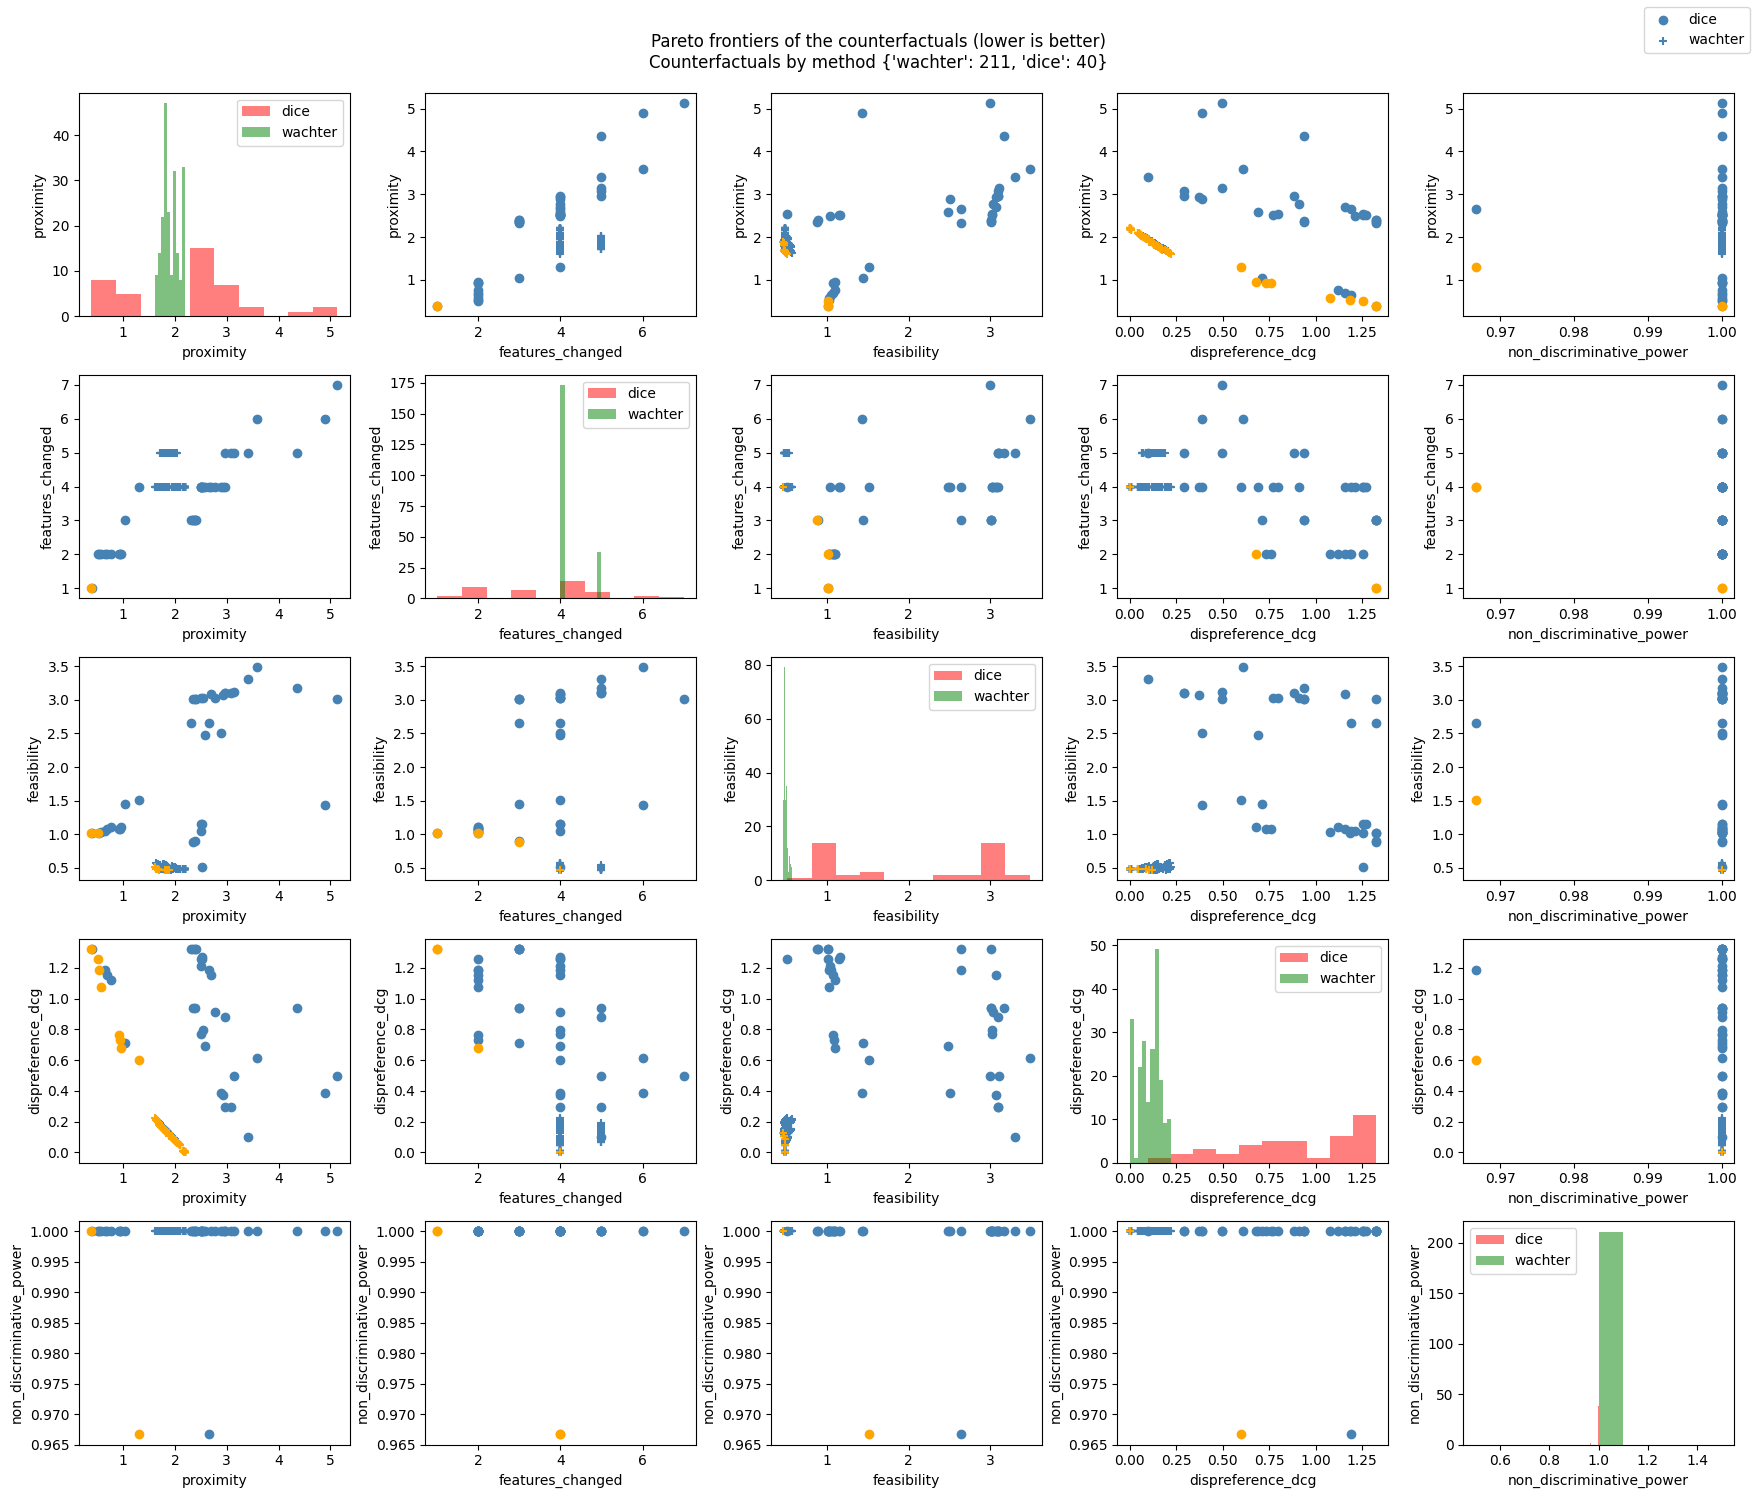

In [19]:

import matplotlib.pyplot as plt

from visualization_helpers import is_pareto_efficient_dumb


metrics_to_plot = ['proximity', 'features_changed', 'feasibility', 'dispreference_dcg', 'non_discriminative_power']
n = len(metrics_to_plot)

fig, ax = plt.subplots(n, n, figsize=(3.5*n, 3*n))

colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']
markers = ['o', '+', 'x', 'v', '^', 's', 't']
labels = []

ax = ax.flatten()

for i, other_metric in enumerate(metrics_to_plot):
    for j, metric in enumerate(metrics_to_plot):

        all_x = scores_df[metric].to_numpy()
        all_y = scores_df[other_metric].to_numpy()
        to_check = np.array([all_x, all_y], dtype=np.float64).T
        all_pareto = get_pareto_frontier_mask(to_check)

        for k, explainer in enumerate(scores_df['explainer'].unique()):

            mask = scores_df['explainer'] == explainer
            pareto = all_pareto[mask]

            x = scores_df[mask][metric].to_numpy()
            y = scores_df[mask][other_metric].to_numpy()

            if i == j:
                ax[i*n+j].hist(x, color=colors[k], label=explainer, alpha=0.5)
                ax[i*n+j].legend()
            else:
                ax[i*n+j].scatter(x[~pareto], y[~pareto], color='steelblue', marker=markers[k], label=explainer)
                ax[i*n+j].scatter(x[pareto], y[pareto], color='orange', marker=markers[k])

        
        ax[i*n+j].set_xlabel(metric)
        ax[i*n+j].set_ylabel(other_metric)
    # plt.title('Proximity vs Dispreference DCG \n(Pareto front in orange). \nLower is better.')

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

counts = scores_df['explainer'].value_counts()

plt.suptitle(f'Pareto frontiers of the counterfactuals (lower is better)\nCounterfactuals by method {counts.to_dict()}\n')
plt.tight_layout()
plt.savefig(f'../images/adult/adult_pairplot_with_frontiers_{instance_to_explain_index}.png')
plt.show()